In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import nfl_data_py as nfl
import datetime as dt
today = dt.date.today()
year = today.year
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = nfl.import_schedules(years=range(2000,year+1))
currSeason = df[df.season == year]
predWeek = currSeason[['week', 'total_line']].dropna()
predWeek = predWeek.week.max()

In [3]:
df = df[['home_team', 'away_team', 'season', 'total', 'game_type', 'week', 'gameday', 'gametime', 'location', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds', 'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'roof', 'surface', 'referee', 'stadium_id']]
df['Over'] = np.where(df['total'] > df['total_line'], 1, 0)
df['Under'] = np.where(df['total'] < df['total_line'], 1, 0)
df['Push'] = np.where(df['total'] == df['total_line'], 1, 0)
df = df[df.Push != 1]
df.drop(columns='total', inplace=True)
df['gameday'] = pd.to_datetime(df['gameday'])
df['DayOfWeek'] = df['gameday'].dt.day_of_week
# Function to convert time to seconds
def time_to_seconds(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60

# Apply the function to the 'time' column
df['gametime'] = df['gametime'].apply(time_to_seconds)
df = pd.get_dummies(df, drop_first=True,columns=['game_type', 'location', 'roof', 'surface', 'referee', 'stadium_id'])
df.reset_index(drop=True, inplace=True)
df = df.dropna()

Total accuracy score=54.45%

Classification Report:
              precision    recall  f1-score   support

        Over       0.51      0.42      0.46       130
       Under       0.57      0.65      0.60       151

    accuracy                           0.54       281
   macro avg       0.54      0.54      0.53       281
weighted avg       0.54      0.54      0.54       281



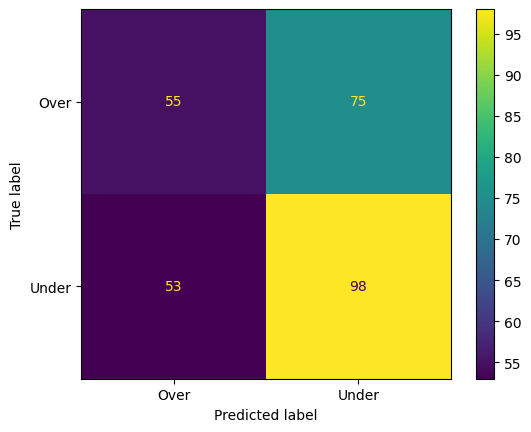

In [4]:
# Model building
feats = df.drop(columns=['home_team', 'away_team', 'season', 'gameday', 'Over', 'Under', 'Push'])
features = feats.columns
target = 'Under'

train_df = df[df.season < df.season.max()-1]
test_df = df[df.season == df.season.max()-1]
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

model = KNeighborsClassifier(n_neighbors=13)
classif = model.fit(X_train, y_train)
y_pred = classif.predict(X_test)
y_true = y_test

print(f'Total accuracy score={accuracy_score(y_true, y_pred):.2%}')
print(f'\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['Over', 'Under']))

cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Over', 'Under'])
display.plot()
plt.grid(False)
plt.show()

In [5]:
train_df = df[(df.season < year) & (df.week < predWeek) | (df.season < year)]
test_df = df[(df.season == year) & (df.week == predWeek)]
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

model = KNeighborsClassifier(n_neighbors=13)
classif = model.fit(X_train, y_train)
y_pred = classif.predict(X_test)

# Predicted Plays log
nextPlays = currSeason[currSeason.week == predWeek]
nextPlays['Predicted Outcome'] = y_pred
nextPlays = nextPlays[nextPlays['Predicted Outcome'] == 1]
nextPlays = nextPlays[['game_id', 'season', 'week', 'home_team', 'away_team', 'gametime', 'weekday', 'total_line', 'under_odds']]
nextPlays.columns = ['Game ID', 'Season', 'Week', 'Home', 'Away', 'Start Time', 'Day', 'Total Line', 'Under Odds']

/var/folders/z2/z8hd8jjx4mnd5sw_1wqj8hch0000gn/T/ipykernel_25112/144663091.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nextPlays['Predicted Outcome'] = y_pred


In [6]:
nextPlays

,Game ID,Season,Week,Home,Away,Start Time,Day,Total Line,Under Odds
6706,2024_01_BAL_KC,2024,1,KC,BAL,20:20,Thursday,46.5,-110.0
6707,2024_01_GB_PHI,2024,1,PHI,GB,20:15,Friday,48.5,-110.0
6709,2024_01_ARI_BUF,2024,1,BUF,ARI,13:00,Sunday,48.0,-110.0
6712,2024_01_HOU_IND,2024,1,IND,HOU,13:00,Sunday,48.0,-110.0
6715,2024_01_MIN_NYG,2024,1,NYG,MIN,13:00,Sunday,41.0,-108.0
6718,2024_01_DAL_CLE,2024,1,CLE,DAL,16:25,Sunday,43.5,-112.0
6720,2024_01_LA_DET,2024,1,DET,LA,20:20,Sunday,51.0,-110.0
6721,2024_01_NYJ_SF,2024,1,SF,NYJ,20:15,Monday,44.0,-108.0
